In [22]:
!pip install imbalanced-learn
!pip install pymysql
!pip install numpy
!pip install matplotlib

  Obtaining dependency information for imbalanced-learn from https://files.pythonhosted.org/packages/6e/1b/66764ecf370e797759be06fb38c11640ea1f9456ae10f8640a33cfa726ea/imbalanced_learn-0.12.2-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/258.0 kB ? eta -:--:--
   ---------------------------------------- 0.0/258.0 kB ? eta -:--:--
   - -------------------------------------- 10.2/258.0 kB ? eta -:--:--
   - -------------------------------------- 10.2/258.0 kB ? eta -:--:--
   ------ -------------------------------- 41.0/258.0 kB 245.8 kB/s eta 0:00:01
   --------- ----------------------------- 61.4/258.0 kB 328.2 kB/s eta 0:00:01
   ---------------- --------------------- 112.6/258.0 kB 504.4 kB/s eta 0:00:01
   ------------------------- ------------ 174.1/258.0 kB 655.4 kB/s eta 0:00:01
   ---------------------------------- --- 235.5/258.0 kB 758.5 kB/s eta 0:00:01
   -------------------------------------- 258.0/258.0 kB 720.2 kB/s eta 0:00:00


In [1]:
from sklearn.utils import resample
import pymysql
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import ListedColormap

from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import metrics


from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

In [2]:
from imblearn.over_sampling import SMOTE

In [24]:
# Database connection
user = '<user>'
password = '<password>'
host = 'localhost'
port = 3306
database = '<db>'

# Establish connection
connection = pymysql.connect(
    host=host,
    port=port,
    user=user,
    password=password,
    database=database
)

# Function to load data from a table
def load_data_from_db(connection, table_name):
    query = f"SELECT * FROM {table_name}"
    return pd.read_sql(query, connection)

# Load training and testing data
training_data = load_data_from_db(connection, 'training_data')
testing_data = load_data_from_db(connection, 'testing_data')

# Close the connection
connection.close()

C:\Users\kevin\AppData\Local\Temp\ipykernel_10100\159293122.py:20: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql(query, connection)


In [25]:
training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22 entries, 0 to 21
Data columns (total 41 columns):
 #   Column                        Non-Null Count  Dtype          
---  ------                        --------------  -----          
 0   home                          22 non-null     int64          
 1   away                          22 non-null     int64          
 2   home_win_probability          22 non-null     float64        
 3   draw_probability              22 non-null     float64        
 4   away_win_probability          22 non-null     float64        
 5   team_to_win_prediction        22 non-null     int64          
 6   average_goals_prediction      22 non-null     float64        
 7   weather_in_degrees            22 non-null     object         
 8   odds                          22 non-null     float64        
 9   full_time_score               22 non-null     object         
 10  score_at_halftime             22 non-null     object         
 11  date                 

In [26]:
testing_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 35 columns):
 #   Column                        Non-Null Count  Dtype          
---  ------                        --------------  -----          
 0   home                          20 non-null     int64          
 1   away                          20 non-null     int64          
 2   home_win_probability          20 non-null     float64        
 3   draw_probability              20 non-null     float64        
 4   away_win_probability          20 non-null     float64        
 5   team_to_win_prediction        20 non-null     int64          
 6   scoreline_prediction          20 non-null     object         
 7   average_goals_prediction      20 non-null     float64        
 8   weather_in_degrees            20 non-null     object         
 9   odds                          20 non-null     float64        
 10  date                          20 non-null     datetime64[ns] 
 11  time                 

In [27]:
# Drop unnecessary columns in order to matche testing_data later on when we validate our models
training_data_columns_to_drop = ['full_time_score', 'score_at_halftime',           
   "home_team_full_time_score",
   "away_team_full_time_score" ,             
   "home_team_halftime_score" ,          
   "away_team_halftime_score" ]
training_data = training_data.drop(columns=training_data_columns_to_drop, axis =1)

In [28]:
# Separate minority and majority classes
loss = training_data[training_data['prediction_result']==0]
win = training_data[training_data['prediction_result']==1]

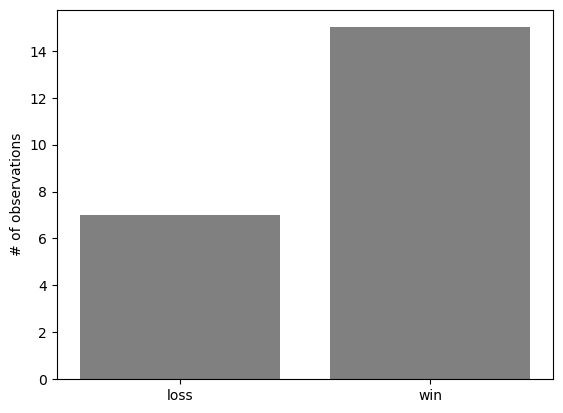

In [29]:
import matplotlib.pyplot as plt
labels = training_data['prediction_result'].unique()
heights = [len(win),len(loss)]
plt.bar(labels,heights,color='grey')
plt.xticks(labels,['win','loss'])
plt.ylabel("# of observations")
plt.show()

In [30]:
loss_upsampled = resample(loss,
                          replace=True, # sample with replacement (we need to duplicate observations)
                          n_samples=len(win), # match number in minority class
                          random_state=27) # reproducible results

# Combine upsampled minority class with majority class
upsampled = pd.concat([loss_upsampled, win])

# Check new class counts
upsampled['prediction_result'].value_counts()

prediction_result
0    15
1    15
Name: count, dtype: int64

In [31]:
X = upsampled.drop(columns=['prediction_result', 'weather_in_degrees','date','time'])
# Define your target variable y
y = upsampled['prediction_result']
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


In [32]:
# Define the names of the classifiers
names = ['Logistic Regression', 'Nearest Neighbors', 
         'Linear SVM', 'RBF SVM',          
         'Decision Tree', 'Random Forest',  'AdaBoost']

#### NOTE TO SELF  
You can use GridSearch to look for the best parameters for each model before proceeding to test their accuracy, but the data isnt enough at the moment 

In [33]:
# Define the classifiers with their respective hyperparameters
classifiers = [
    LogisticRegression(max_iter=20000, solver='lbfgs'), 
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),    
    AdaBoostClassifier()
]

In [34]:
# Empty lists to store results
results = []  # Store evaluation metrics for each classifier
models = {}  # Store trained models
confusion = {}  # Store confusion matrices for each classifier
class_report = {}  # Store classification reports for each classifier

# Iterate over each classifier
for name, clf in zip(names, classifiers):    
    print ('Fitting {:s} model...'.format(name))
    # Measure the time taken to fit the model
    run_time = %timeit -q -o clf.fit(X_train_resampled, y_train_resampled)
    
    print ('... predicting')
    # Predict on the test data
    y_pred_test = clf.predict(X_test)
    
    print ('... scoring')
    # Calculate evaluation metrics
    accuracy  = metrics.accuracy_score(y_test, y_pred_test)
    precision = metrics.precision_score(y_test, y_pred_test)
    recall    = metrics.recall_score(y_test, y_pred_test)
    
    f1_test   = metrics.f1_score(y_test, y_pred_test)    
    
    # Save the results to dictionaries
    models[name] = clf    
    confusion[name] = metrics.confusion_matrix(y_test, y_pred_test)
    class_report[name] = metrics.classification_report(y_test, y_pred_test)
    
    # Append results to the list
    results.append([name, accuracy, precision, recall, f1_test, run_time.best])

    
# Convert results to DataFrame for easy visualisation
results = pd.DataFrame(results, columns=['Classifier', 'Accuracy', 'Precision', 'Recall', 'F1 Test', 'Train Time'])
results.set_index('Classifier', inplace= True)

print ('... All done!')

Fitting Logistic Regression model...
... predicting
... scoring
Fitting Nearest Neighbors model...
... predicting
... scoring
Fitting Linear SVM model...
... predicting
... scoring
Fitting RBF SVM model...
... predicting
... scoring
Fitting Decision Tree model...
... predicting
... scoring
Fitting Random Forest model...
... predicting
... scoring
Fitting AdaBoost model...
... predicting
... scoring
... All done!


In [35]:
results.sort_values('F1 Test', ascending=False)

,Accuracy,Precision,Recall,F1 Test,Train Time
Classifier,,,,,
RBF SVM,1.000000,1.0,1.00,1.000000,0.002253
Logistic Regression,0.833333,1.0,0.75,0.857143,0.032639
Nearest Neighbors,0.666667,1.0,0.50,0.666667,0.001986
Linear SVM,0.666667,1.0,0.50,0.666667,0.002215
Decision Tree,0.666667,1.0,0.50,0.666667,0.002098
Random Forest,0.666667,1.0,0.50,0.666667,0.015072
AdaBoost,0.666667,1.0,0.50,0.666667,0.065195


Text(0.5, 1.0, 'Training Time vs. Classifier')

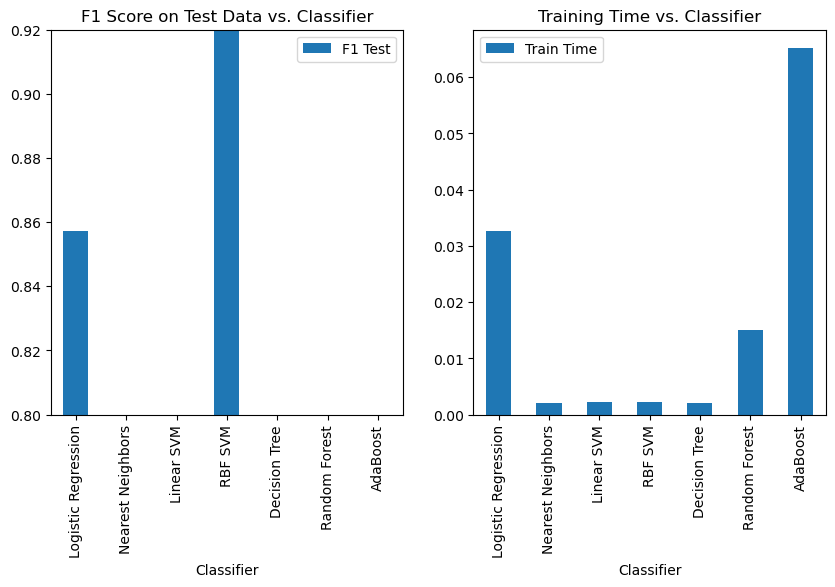

In [36]:
# Plot F1 Score on Test Data vs. Classifier
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
# results.sort_values('F1 Train', ascending=False, inplace=True)
results.plot(y=['F1 Test'], kind='bar', ax=ax[0], xlim=[0,1.1], ylim=[0.80,0.92])
ax[0].set_title('F1 Score on Test Data vs. Classifier')
results.plot(y='Train Time', kind='bar', ax=ax[1])
ax[1].set_title('Training Time vs. Classifier')

In [37]:
# Display confusion matrices and classification reports
for name, matrix in confusion.items():
    print(f"Confusion Matrix for {name}:")
    print(matrix)
    print()
    
for name, report in class_report.items():
    print(f"Classification Report for {name}:")
    print(report)
    print()

Confusion Matrix for Logistic Regression:
[[2 0]
 [1 3]]

Confusion Matrix for Nearest Neighbors:
[[2 0]
 [2 2]]

Confusion Matrix for Linear SVM:
[[2 0]
 [2 2]]

Confusion Matrix for RBF SVM:
[[2 0]
 [0 4]]

Confusion Matrix for Decision Tree:
[[2 0]
 [2 2]]

Confusion Matrix for Random Forest:
[[2 0]
 [2 2]]

Confusion Matrix for AdaBoost:
[[2 0]
 [2 2]]

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         2
           1       1.00      0.75      0.86         4

    accuracy                           0.83         6
   macro avg       0.83      0.88      0.83         6
weighted avg       0.89      0.83      0.84         6


Classification Report for Nearest Neighbors:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67         2
           1       1.00      0.50      0.67         4

    accuracy                           0.67         6
  

Lets test the models with the testing_data

In [40]:
testing_data= testing_data.drop(columns=['scoreline_prediction', 'weather_in_degrees','date','time'])

In [41]:
testing_data.columns

Index(['home', 'away', 'home_win_probability', 'draw_probability',
       'away_win_probability', 'team_to_win_prediction',
       'average_goals_prediction', 'odds', 'home_team_score_prediction',
       'away_team_score_prediction', 'day_of_week', 'month', 'weekly_round',
       'home_team_pos', 'home_team_matches_played', 'home_team_wins',
       'home_team_draws', 'home_team_losses', 'home_team_gf', 'home_team_ga',
       'home_team_ppg_last_5_matches', 'home_team_points', 'away_team_pos',
       'away_team_matches_played', 'away_team_wins', 'away_team_draws',
       'away_team_losses', 'away_team_gf', 'away_team_ga',
       'away_team_ppg_last_5_matches', 'away_team_points'],
      dtype='object')

In [38]:
X_test.columns

Index(['home', 'away', 'home_win_probability', 'draw_probability',
       'away_win_probability', 'team_to_win_prediction',
       'average_goals_prediction', 'odds', 'home_team_score_prediction',
       'away_team_score_prediction', 'day_of_week', 'month', 'weekly_round',
       'home_team_pos', 'home_team_matches_played', 'home_team_wins',
       'home_team_draws', 'home_team_losses', 'home_team_gf', 'home_team_ga',
       'home_team_ppg_last_5_matches', 'home_team_points', 'away_team_pos',
       'away_team_matches_played', 'away_team_wins', 'away_team_draws',
       'away_team_losses', 'away_team_gf', 'away_team_ga',
       'away_team_ppg_last_5_matches', 'away_team_points'],
      dtype='object')

### Note
Okay so if you look back into Logistic Regression Notebook, in my models directory. You will notice that i had hardcoded the results of the completed matches for validating our logistic model. The unfortunate thing is the testing_data has duplicate values due to me constantly trying to see if my code is working. I left the duplicate just because.  
I am working on a way to automate validation. but i will have to restructure the flow of data and that will take a while to ensure its robust and theres no leakage or `duplicates` again. Bare with me. Once you have the code im sure you can find a fix for this :)

In [44]:
y_testing_data = [0,1,1,1,1,0,1,1,1,1,0,1,1,1,1,0,1,1,1,1]

In [45]:
# Empty lists to store results
results = []  # Store evaluation metrics for each classifier
models = {}  # Store trained models
confusion = {}  # Store confusion matrices for each classifier
class_report = {}  # Store classification reports for each classifier

# Iterate over each classifier
for name, clf in zip(names, classifiers):    
    print ('Fitting {:s} model...'.format(name))
    # Measure the time taken to fit the model
    run_time = %timeit -q -o clf.fit(X_train_resampled, y_train_resampled)
    
    print ('... predicting')
    # Predict on the test data
    y_pred_test = clf.predict(testing_data)
    
    print ('... scoring')
    # Calculate evaluation metrics
    accuracy  = metrics.accuracy_score(y_testing_data, y_pred_test)
    precision = metrics.precision_score(y_testing_data, y_pred_test)
    recall    = metrics.recall_score(y_testing_data, y_pred_test)
    
    f1_test   = metrics.f1_score(y_testing_data, y_pred_test)    
    
    # Save the results to dictionaries
    models[name] = clf    
    confusion[name] = metrics.confusion_matrix(y_testing_data, y_pred_test)
    class_report[name] = metrics.classification_report(y_testing_data, y_pred_test)
    
    # Append results to the list
    results.append([name, accuracy, precision, recall, f1_test, run_time.best])

    
# Convert results to DataFrame for easy visualisation
results = pd.DataFrame(results, columns=['Classifier', 'Accuracy', 'Precision', 'Recall', 'F1 Test', 'Train Time'])
results.set_index('Classifier', inplace= True)

print ('... All done!')

Fitting Logistic Regression model...
... predicting
... scoring
Fitting Nearest Neighbors model...
... predicting
... scoring
Fitting Linear SVM model...
... predicting
... scoring
Fitting RBF SVM model...
... predicting
... scoring
Fitting Decision Tree model...


C:\Users\kevin\anaconda3\envs\Alx_DataScience_env\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\kevin\anaconda3\envs\Alx_DataScience_env\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\kevin\anaconda3\envs\Alx_DataScience_env\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

... predicting
... scoring
Fitting Random Forest model...
... predicting
... scoring
Fitting AdaBoost model...
... predicting
... scoring
... All done!


In [46]:
results.sort_values('F1 Test', ascending=False)

,Accuracy,Precision,Recall,F1 Test,Train Time
Classifier,,,,,
RBF SVM,0.8,0.800000,1.000,0.888889,0.002296
AdaBoost,0.8,0.875000,0.875,0.875000,0.056139
Nearest Neighbors,0.7,1.000000,0.625,0.769231,0.001973
Decision Tree,0.7,1.000000,0.625,0.769231,0.002190
Random Forest,0.7,1.000000,0.625,0.769231,0.015331
Logistic Regression,0.6,0.833333,0.625,0.714286,0.033801
Linear SVM,0.6,0.833333,0.625,0.714286,0.002305


### CONCLUSION

- Keep in mind i had only 2 weekly rounds of data, thats maybe around 20 matches and 20 predictions to test these various models.
- Also there was data imbalance, this arises when the betting tip sites either win alot of their predictions or lose alot.
So i resampled using SMOTE, leading to duplicated data. Which in turn is a major drawback for training models, because you get high accuracy during training but little accuracy with new data. All in all we got three good models during training that we will create different notebooks for and explore them furthur 

- Logisitc Regression
- Random Forest
- RBF SVM

However When we tested our models on unseen data (although there were duplicates) we had a suprise increase in accuracy for certain models like

- Nearest Neighbors	
- Decision Tree	
- AdaBoost

Im new to RBF so that will be interesting to play around with it.
I cant wait to try all these models separately. I have started and completed Logistic regresion. I had some pretty good results.
I come back to this notebook anytime i have ideas i want to play around with it


It is always important to come back to this notebook and edit, tune, compare all the models again as the data increases and then with new information go back to the separate notebooks you have dedicated to your separate models and reaccess their accuracy by tuning certain parameters.
Also depending on the upcoming fixtures, maybe certain models will work with higher odds or different types of fixtures so keep testing these models as the data increase and over time you will have your favorite and reliable one.

I will urge you to try PCA to look at ML from a different approach to also help classification and selecting strong features.
Have fun!